# Load and initialize


settings


In [21]:
# sample number

j = '_raw'+'14.2'+'a'
# j = '14.2'+'a'
# j = '14.4'

group_ind = 3
dir_data1 = 'Data_'

args = {
        # create visualization (umap, dbscan are always shown)
        'visualize':True,'plotUMAP' : True,
        # show figures in notebook
        'show' : True, 'saveSVG' :False,
        # calculate umap
        'calc_umap' : False
        }
create_adjusted = False
print(j)

_raw14.2a


envirement


In [22]:

from tqdm import tqdm_notebook, tqdm
import datetime

import pandas as pd
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import sys
import pathlib
import os
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
import time
start = time.process_time()
date = datetime.date.today().strftime("%d%m%Y")
# import time

# import matplotlib

plt.rcParams["figure.figsize"] = (5.0, 4.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 180)  # according to screen width
# from pandas.core.base import PandasObject
# PandasObject.view = view #allows view meth pd.view

# from scipy import signal, stats
# import seaborn as sns

# from sklearn import metrics

# from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
# from sklearn.metrics import silhouette_samples,silhouette_score
# from sklearn.neighbors import kneighbors_graph

# from lmfit import minimize, Parameters


parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir+'/functions/')

# from epinuc import *
from usefull_functions import *
from functions import *
from plot_functions import *
from clustering_functions import *
from xg_shap import *    


%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%autoreload 2


# TF_ENABLE_ONEDNN_OPTS=0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


load data; normalized (CD45-)


In [23]:
j, group_ind, dir_data1,args = getJ(j, group_ind, dir_data1,args)



dir_data = os.path.abspath(os.path.join(    parent_dir, os.pardir))+f'/{dir_data1}/'
dir_plots = os.path.abspath(os.path.join(
    parent_dir, os.pardir))+f'/_sample_{j}_{dir_data1}_{date}/'
folderExists(dir_plots)
settings = (dir_plots, args['show'], args['saveSVG'])

if 'b' not in j:
    singleSample = True
else:
    singleSample = False
print(f'singleSample is: {singleSample}')

# k_orig = pickle_load('k'+j+'_dict',dir_data )['k']
# k = k_orig.copy()
# CAll=pd.concat([k]).copy()

k = pickle_load('k'+j+'_dict', dir_data)['k']
CAll = pd.concat([k.copy()])
print(len(k))


names_dict = pickle_load('k'+j+'_names_dict', dir_data)
if '14.2a' in j: #remove them from the names_dict; they need to be only in cellcycle
    names_dict = removeFeatures(names_dict.copy(),features =['CyclinB1', 'pRB','H3S28p','DNA2'])#


NamesAll = names_dict['NamesAll']
CellIden = names_dict['CellIden']
EpiCols = names_dict['EpiCols']
Core = names_dict['Core']
CellIden_EpiCols = CellIden + EpiCols

# dict = None

groups = [['CellIden', 'EpiCols', 'CellIden+EpiCols',],
          [CellIden, EpiCols, CellIden_EpiCols]]

names = [[f'samp{j}_CellIden_', f'samp{j} CellIden Based'],
         [f'samp{j}_EpiCols_', f'samp{j} EpiCols Based'],
         [f'samp{j}_CellIden+EpiCols_', f'samp{j} CellIden+EpiCols Based'],
         ]

params = ['iden', 'epi', 'all',]

if '14.2a'in j and group_ind==3:
    groups[0].append( 'CellCycle')   
    groups[1].append( ['CyclinB1', 'pRB','H3S28p','DNA2'] )   
    names.append(   [f'samp{j}_CellCycle_', f'samp{j} CellCycle Based'])
    params.append('cell')

current j = _raw14.2a,group_ind = 3, add = Data_
singleSample is: True
k_raw14.2a_dict ; loaded from file
4527
k_raw14.2a_names_dict ; loaded from file


Visualize data

no point to print data.describe() as it is whitened (std~1, mean~0)


In [24]:
# if show:

#     for features in [NamesAll,Core,CellIden,EpiCols,CellIden_EpiCols]:
#         print(len(features))
#         print(features)


# Cell Identity


In [25]:

figname, title = names[group_ind]
name, featureGroup = groups[0][group_ind], groups[1][group_ind]
print(name, title, figname)


CellCycle samp_raw14.2a CellCycle Based samp_raw14.2a_CellCycle_


### UMAP

plot for each feature according to its intensity


min_dist:0.1, n_neighbors:10
umapData_samp_raw14.2a_CellCycle_ ; loaded from file


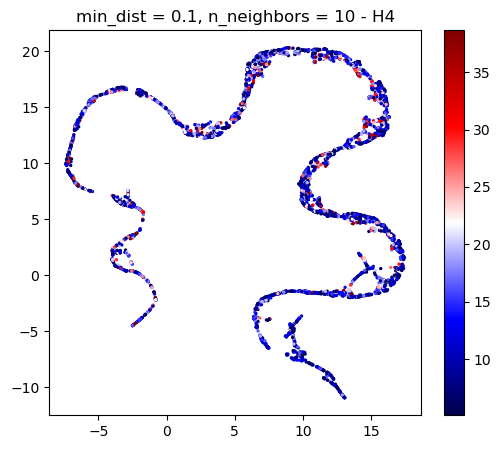

In [26]:

min_dist, n_neighbors = getValsCsv(    dir_data, vars=[params[group_ind], 'umap', j])
# min_dist, n_neighbors = 0.02,10
print(f'min_dist:{min_dist}, n_neighbors:{n_neighbors}')
# calc_umap = True
if args['calc_umap']:
    umapData = calculate_umap(CAll[featureGroup].copy(), n_neighbors, min_dist)
    pickle_dump(f'umapData_{figname}', umapData, dir_data)
else:
    umapData = pickle_load(f'umapData_{figname}', dir_data)
drawUMAP(umapData, ['H4'], CAll, settings,
         title=f'min_dist = {min_dist}, n_neighbors = {n_neighbors}',
         Figname='1_'+figname+'UMAP_(core)')


In [27]:
print(len(k))
CAll[featureGroup].columns

4527


Index(['CyclinB1', 'pRB', 'H3S28p', 'DNA2'], dtype='object')

### Dbscan and clusters


Dbscan


0.15, 40
Estimated number of clusters: 3
Estimated number of noise points: 0
Silhouette Coefficient: 0.161


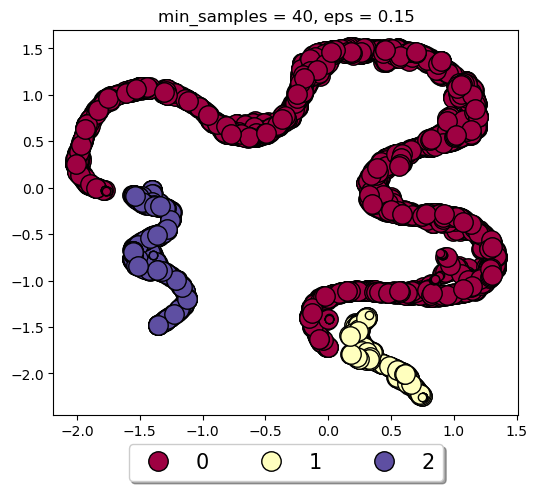

In [28]:
eps, min_samples = getValsCsv(dir_data, vars=[params[group_ind], 'db', j])
# eps,min_samples = 0.1,40
print(f'{eps}, {min_samples}')

dbscanData, labels, core_samples_mask  = calculate_dbscan(umapData,list(k.index), eps, min_samples)
colors = drawDbscan(dbscanData, labels, core_samples_mask, settings,
                    title=f'min_samples = {min_samples}, eps = {eps}',
                    figname='1_'+figname+'dbscan')
k['Clust'] = labels
pickle_dump(f'dbLabels_{figname}', labels, dir_data);pickle_dump(f'dbColors_{figname}', colors, dir_data)


kmeans

converged after 25 iterations


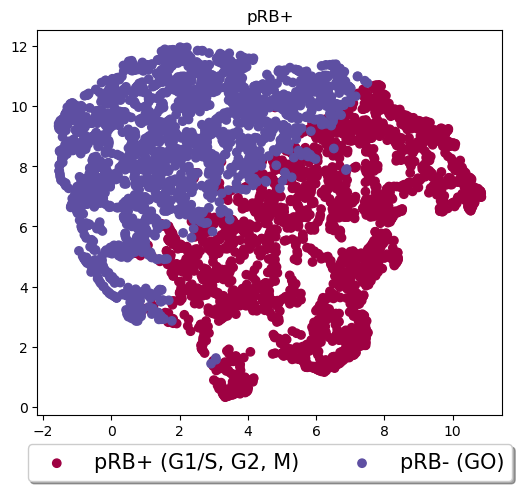

converged after 16 iterations


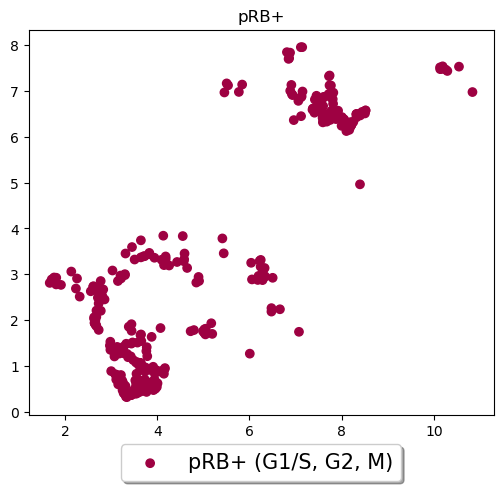

In [20]:
if '14.2a' in j and group_ind == 3:

    labels = kmeans_fit(np.hstack ((umapData.copy(),CAll[[ 'pRB']].copy()))
                        ,n_clusters=2,n_init=10,max_iter=300)


    colors = draw_kmeans(data = umapData.copy(),labels = labels,title='pRB+',figname='kmeans_pRB_',settings = settings,
                names =['pRB+ (G1/S, G2, M)','pRB- (GO)'])


    ind = [i for i,j in zip(k.index,labels) if j==0]
    # colors = draw_kmeans(data = umapData.copy()[ind],labels = labels[ind],title='pRB+',figname='kmeans_pRB_',settings = settings,
    #         names =['pRB+ (G1/S, G2, M)'])
    
    labels1 = kmeans_fit(CAll[['CyclinB1']].loc[ind].copy(),n_clusters=2,n_init=10,max_iter=300)
    ind1 = [i for i,j in zip(ind,labels1) if j==0]
    colors = draw_kmeans(data = umapData.copy()[ind1],labels = labels[ind1],title='pRB+',figname='kmeans_pRB_',settings = settings,
        names =['pRB+ (G1/S, G2, M)'])
    # ind2 = [i for i,j in enumerate(labels1) if j==0]
    # labels[ind1] = labels1[ind2]+2

    # labels2 = kmeans_fit(CAll[['H3S28p']].loc[ind].copy(),n_clusters=2,n_init=10,max_iter=300)
    # ind1 = [i for i,j in zip(ind,labels2) if j==0]
    # ind2 = [i for i,j in enumerate(labels2) if j==0]
    # labels[ind1] = labels2[ind2]+2

    # colors = draw_kmeans(data = umapData.copy(),labels = labels,title='kmeans all clusters',figname='kmeans_all_clusters',settings = settings,
    #             names =['not M&G1','pRB- (GO)','M&G2'])
    
    # pickle_dump(f'kmeanLabels_{figname}', labels, dir_data);pickle_dump(f'kmeanColors_{figname}', colors, dir_data)




adjusted dataset


k14.2; samples =  4527 , features =  38 ; saved to file


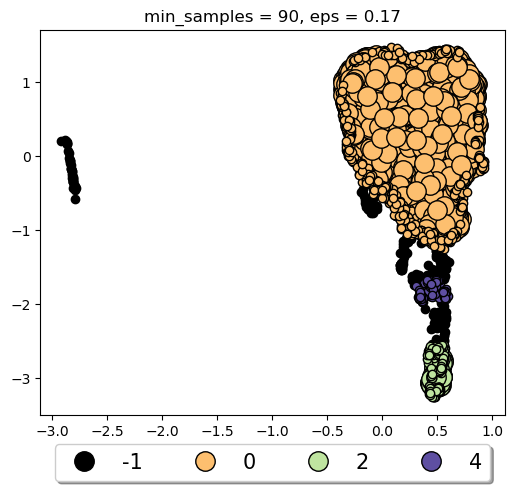

4527


In [69]:

# create_adjusted = True
if (j == 'b234' or j == '14.2') and group_ind==2 and create_adjusted:
    dir_indexes =  '/home/yishai/breast_cancer/indexes/'
    kInd = j+'a'

    clusters = [3,1]  # clusters to remove #1, 3#3,5
    idx_ = ~np.zeros_like(labels).astype(bool)
    for cluster in clusters:
        idx_ *= ~(labels == cluster)
    idx = np.asarray([i for i, j in enumerate(idx_) if j])
    newK = k.copy().reset_index(drop = True).loc[idx]
    print (f'k{j}; samples = ', len(newK), ', features = ', len(newK.columns),'; saved to file')



    colors = drawDbscan(dbscanData[idx], labels[idx], core_samples_mask[idx], settings,
                        title=f'min_samples = {min_samples}, eps = {eps}',
                        figname='1_'+figname+'dbscan_adjusted')
    # plotClusters(newK, umapData[ind], labels[ind], colors, NamesAll, settings,
    #              title='Clusters ' + title,
    #              figname='1_'+figname+'Clusters_adjusted')

    dict = None;dict ={}
    dict['k'] = newK.copy()
    pickle_dump(f'{kInd}_dict', dict,dir_data)
    pickle_dump(f'k{kInd}_names_dict', names_dict,dir_data)
    ind = np.asarray(newK['ind'].copy())   
    pickle_dump(f"{kInd}_indexes", ind,dir_indexes)
    # for kInd in newK['samp'].unique():
        
    #     newK_ = newK[newK['samp']==kInd].copy()
    #     ind = np.asarray(newK_['ind'].copy())
    #     kInd = int(kInd) if (kInd!=4.1 and kInd!=7.1) else float(kInd)
    #     print(kInd)
    #     pickle_dump(f"{kInd}a_indexes", ind,dir_indexes)


clusters

### HeatMap by clusters


In [10]:
from plot_functions import *

if args['visualize']:
    
    for group_name, group in zip(groups[0], groups[1]):
        
        HeatMap(k[labels != -1], group, settings,clustFeature='Clust',
                title='HeatMap ' + title + ': '+group_name,
                figname='1_'+figname+'ClustHeatMap_by_'+group_name)
    


specific clusters and features

In [11]:
# from plot_functions import *
# if args['visualize']:
#     clusters =[0,1]
#     group_name, group = 'specific_markers', ['H3K9me2', 'H3K4me3','H3K36me3','H4K20me3']
#     kk=k.copy()
#     # -----------------
#     k = k.loc[[True if c in clusters else False for c in k['Clust'] ]]
#     HeatMap(k, group, settings,clustFeature='Clust',
#     title='HeatMap ' + title + ': '+group_name,
#                 figname='1_'+figname+'ClustHeatMap_by_'+group_name)
#     # ---------------------
#     k=kk.copy()
#     kk = None



### HeatMap by sample


In [12]:
if args['visualize'] and not singleSample:
    group_name, group = groups[0][-1], groups[1][-1]
    HeatMap(k[labels != -1], group, settings, clustFeature='by_sample',
            title='HeatMap ' + title + ': ' + group_name+' by_sample',
            figname='1_'+figname+'SampHeatMap_'+group_name)


### MeanDist


In [13]:

if args['visualize']:
    for group_name, group in zip(groups[0], groups[1]):
        MeanDist(k[labels == 0], k[labels == 1], group, settings,
                title='MeanDist ' + title + ': '+group_name,
                figname='1_'+figname+'ClustMeanDist_by_'+group_name)


## sample percentage


by sample

In [14]:
# from plot_functions import *
if args['visualize'] and not singleSample:
    # unique by_sample values
    for sampNum in np.unique(k['by_sample']):
        ind_samp = [i for i, j in enumerate(k.by_sample == sampNum) if j]
        labels_samp = np.ones(len(ind_samp))*sampNum
        drawUMAPbySample(umapData, k, ind_samp, labels_samp, settings,
                         title=title+f' UMAP - by_sample={sampNum}',
                         Figname='4_'+figname+f'UMAP_sample{sampNum}_by_sample')
    arr = []
    clustNums = np.unique(k.Clust)
    clustNums = clustNums[clustNums != -1]
    for clustNum in clustNums:
        ind = k.Clust == clustNum
        PercentageBySample = ClustPercentageBySample(k[ind], 'by_sample')

        arr.append([clustNum, PercentageBySample])
    saveCsv(dir_plots, figname, arr)


all samples

In [15]:
# from plot_functions import *


if args['visualize'] and not singleSample:
    # remove 4.1,7.1 and subsample 
    ind_samp =k.index.values[[ True  if i!='4.1' and i!='7.1' else False for i in k.by_sample]]
    ind_samp=np.random.choice(ind_samp, replace = False, size = int(len(k)/4))
    labels_samp = np.asarray(k.by_sample).astype(int)[ind_samp]

    # ind_samp = k.index.values
    # labels_samp = np.asarray(k.by_sample)[ind_samp]


    colors_samp = np.zeros((np.max(labels_samp)+2,4))
    hex = ['00B3A4','3185FC','DB1374','490092','FEB6DB','F98510','E6C220','BFA180','920000','461A0A']
    colors_samp[1+np.unique(labels_samp)] = np.asarray([hex_to_rgba(h) for h in hex])[:np.unique(labels_samp).shape[0]]
    drawUMAPbySample(umapData, k, ind_samp, labels_samp, settings,colors_samp,backgroundColor = 'white',
                        title=title+f' UMAP - by_sample=ALL',
                        Figname='4_'+figname+f'UMAP_sampleAll_by_sample')
 


by cluster

In [16]:
from plot_functions import *
if args['visualize'] and not singleSample:
    # plt.scatter(umapData[:,0],umapData[:,1],c = 'lightgrey', alpha=0.2,s=2)
    uniq = [int(i) if (np.round(i,1) - np.round(i,0)==0) else float(i)  for i in np.unique(k['by_sample'])]
    # print(uniq)
    # unique by_sample values
    for sampNum in uniq:
        # sampNum = uniq[-1]

        # ind_umap = [i for i, j in enumerate(k.by_sample == sampNum) if j]
        # labels_samp = np.asarray(pickle_load(f'dbLabels_samp{sampNum}_{name}_', dir_data))
        
        # sample indexs which are the full dataset - filter db labels by it
        ind_samp = [i for i, j in zip(k.Ind,k.by_sample == sampNum) if j]
        # corresponding indexes in the full data set - where each point in the full umap
        ind_umap = [i for i, j in zip(k.index,k.by_sample == sampNum) if j]        
        labels_samp = np.asarray(pickle_load(f'dbLabels_samp{sampNum}_{name}_', dir_data))[ind_samp]
        # colors_samp = pickle_load(f'dbColors_samp{sampNum}_{name}_', dir_data)
        colors_samp = np.vstack(([0,0,0,1],np.asarray(pickle_load(f'dbColors_samp{sampNum}_{name}_', dir_data))))
        # pickle_dump(f'dbColors_{figname}', colors, dir_data)

        drawUMAPbySample(umapData, k, ind_umap, labels_samp, settings,colors_samp,
                         title=title+f' UMAP - by_sample={sampNum} clusters',
                         Figname='4_'+figname+f'UMAP_sample{sampNum}_by_sample_clusters')
        
# [4, 4.1, 5, 7, 7.1, 8, 11, 13, 14, 15]


14.2_adj

In [17]:
# from plot_functions import *
if j == '14.2_adj' and group_ind==2:  
    k['kmean_labels'] = pickle_load('kmeanLabels_samp14.2_adj_CellCycle_', dir_data).astype(float)
    # colors = draw_kmeans(data = umapData.copy(),labels = labels,title='kmeans all clusters',figname='kmeans_all_clusters',settings = settings,
    #             names =['not M&G1','pRB- (GO)','M&G1'])

    arr = []
    clustNums = np.unique(k.Clust)
    clustNums = clustNums[clustNums != -1]
    for clustNum in clustNums:
        ind = k.Clust == clustNum
        PercentageBySample = ClustPercentageBySample(k[ind], 'kmean_labels',names =['not M&G1','pRB- (GO)','M&G1'])

        arr.append([clustNum, PercentageBySample])

    saveCsv(dir_plots, f'{j}_cellcycle_clusters', arr)

## features on UMAP


shap

In [18]:
if args['visualize'] and args['plotUMAP']:
    ind = labels !=-1 # drop unclustered rows (clust==-1)
    accuracy = xg_classification_shap(CAll[featureGroup].copy(),labels.copy(),ind,colors,
                                    settings,figname='5_'+figname+'shap')
    print(f"accuracy {j}_{group_ind}: {accuracy}%")

plot Clusters

In [19]:
if args['visualize'] and args['plotUMAP']:
    plotClusters(k, umapData, labels, colors, NamesAll, settings,
                title='Clusters ' + title,
                figname='1_'+figname+'Clusters')

plot features on umap 

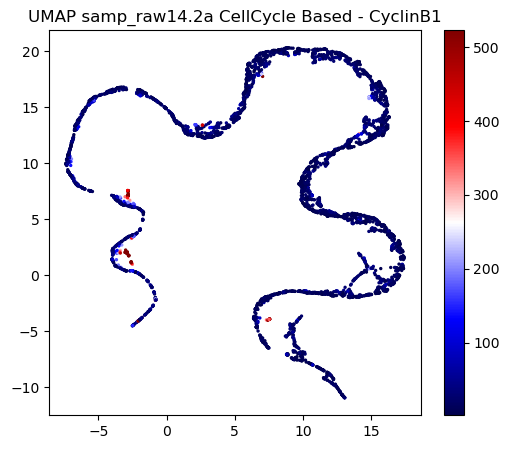

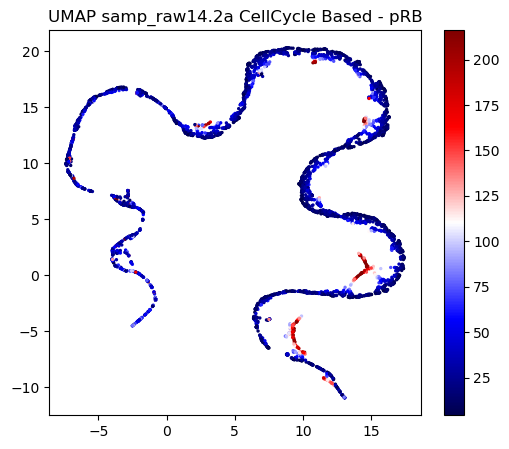

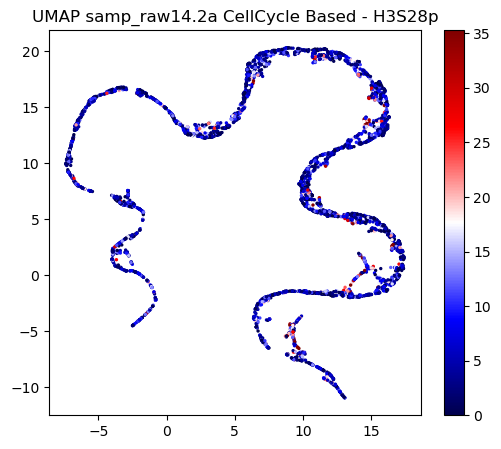

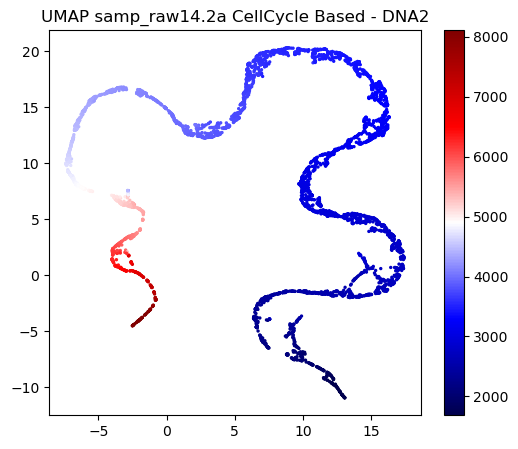

In [30]:
if args['visualize'] and args['plotUMAP']:
    drawUMAP(umapData, ['CyclinB1', 'pRB','H3S28p','DNA2'], CAll, settings,
             title='UMAP ' + title,
             Figname='2_'+figname+'UMAP_')


## scatter figures


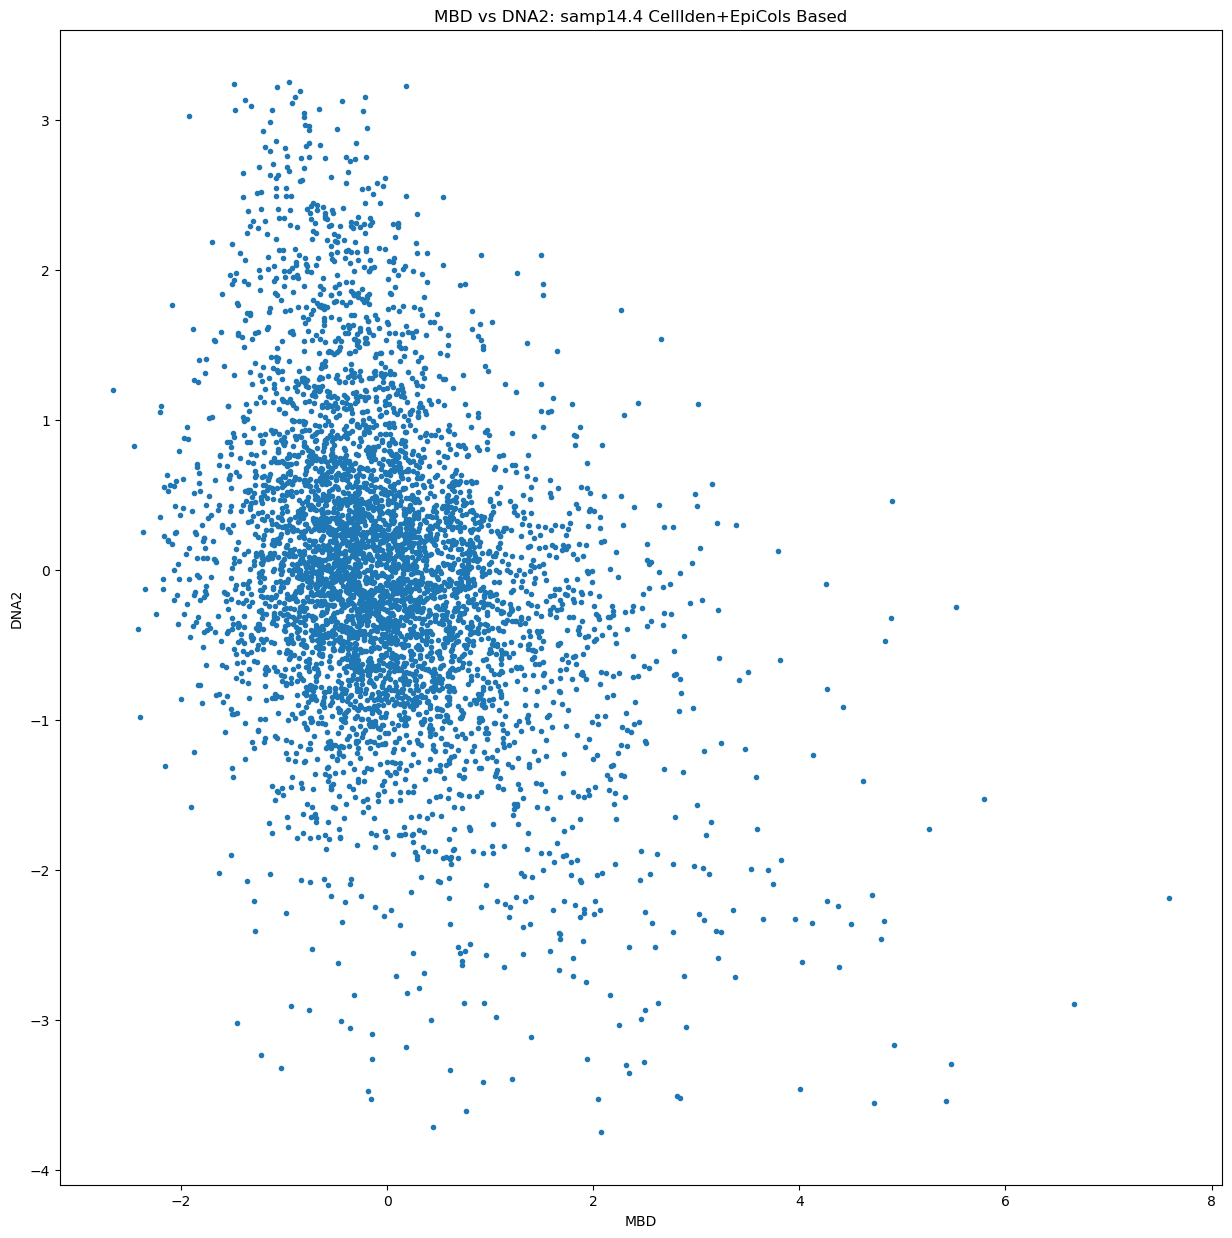

In [54]:
if args['visualize']:
    try:
        scatter(k, 'MBD', 'DNA2', title, figname, settings)
    except:
        print('no ncad in sample')
# k.columns

## clear data


In [22]:
# dbscanData, umapData,k, CAll,labels = None,None,None,None,None
# imList2pdf(dir_plots,j,['CellIden','EpiCols','CellIden+EpiCols'])
